# Industry energy demand

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'EDeMOS':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\EDeMOS


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd

# Spatial
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from pyproj import CRS
from rasterstats import zonal_stats

# Plot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
import config
from utils import processing_raster, finalizing_rasters, spatialjoinvectors
from Industry import energy_per_site
from Industry.data_loader import load_initial_data, load_and_process_energy_balance

In [4]:
pd.options.display.float_format = '{:,.4f}'.format

### Define area of interest

In [5]:
area = config.AREA_OF_INTEREST
# area = "Copperbelt"

### Import admin layers

In [6]:
regions_list, admin_gdf, region_gdf, grid, hexagons = load_initial_data(config)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (122901, 11)


# Part 1. Extract GIS-based attributes

## Extract information from vector layers

Assess the energy consumption per site

In [7]:
## Running the energy calculation function 
from Industry import energy_per_site

energy_per_site.calc_energy_per_site(config)

Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mkushi Heap Leach  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mufulira West Heap-Leach Facility  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  TD3a, TD3b, TD5, and TD7 Tailings Dams  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
File exists. Deleting it now...
File deleted.
Layers found in 'C:\Users\amillot\PycharmProjects\EDeMOS\Industry\Data\mines\mineral_facilities_zambia.gpkg':
- mines


Extract sum production of mines in each cluster (hex)

In [8]:
grid, mines = spatialjoinvectors(config.COL_ELEC_CONS_TJ, admin_gdf, config.CRS_WGS84, grid, "sum", config.MINES_OUTPUT_GPKG)
grid, mines_data = spatialjoinvectors(config.COL_COPPER_ELEC_CONS_TJ, admin_gdf, config.CRS_WGS84, grid, "sum", config.MINES_OUTPUT_GPKG)

CRS matched successfully for points_correct.
CRS matched successfully for points_correct.


In [9]:
grid[config.COL_ELEC_CONS_TJ].sum()

np.float64(18730.48350313929)

In [10]:
grid[config.COL_COPPER_ELEC_CONS_TJ].sum()

np.float64(16267.012581639288)

In [11]:
grid.head(2)

,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ
0,8796ad7aeffffff,38626,102916,"92,538.0000","67,600.0000","65,774.0000","50,193.0000",0,Northern,1,"POLYGON ((30.51733 -8.8264, 30.50486 -8.83274,...",NaN,NaN
1,87961351cffffff,108861,81154,"9,479.0000","35,849.0000","46,295.0000","53,650.0000",1,Northern,2,"POLYGON ((31.42423 -10.09492, 31.41174 -10.101...",NaN,NaN


In [12]:
mines.head(2)

,Country,FeatureNam,DsgAttr02,DsgAttr03,DsgAttr06,MemoOther,MemoLoc,Latitude,Longitude,DsgAttr07,...,Mine type,Metal processing,Metal process type,Spec energy Elec [GJ/t],Spec energy Diesel [GJ/t],ind_elec_TJ,ind_diesel_TJ,copper_elec_TJ,id,geometry
0,Zambia,Baluba Center Underground Mine,Copper,Concentrate,2017,Ore. Operations suspended. Facility on care-an...,<null>,-13.0486,28.3381,"1,500,000.0000",...,Underground,,,11.7500,2.1500,140.3285,25.6771,140.3285,1,POINT (28.33806 -13.04861)
1,Zambia,Bwana Mkubwa Solvent Extraction-Electrowinning...,Copper,Metal,2017,Copper cathode.,<null>,-13.0423,28.7094,"52,000.0000",...,,Hydrometallurgical,"Solvent Extraction-Electrowinning, Electrowinn...",12.4950,2.2050,202.7189,35.7739,202.7189,2,POINT (28.70935 -13.0423)


# Part 2. Compute demand

In [13]:
un_energy_data = load_and_process_energy_balance(config)

Loading and processing energy balance data...
Energy balance data processed. UN stats:
elec_nonFerrousMetals_TJ: 22,897.0 TJ
elec_mining_TJ: 818.0 TJ
oil_nonFerrousMetals_TJ: 1,191.1 TJ
oil_mining_TJ: 2,689.7 TJ
elec_ind_TJ: 23,715.0 TJ
oil_ind_TJ: 3,880.8 TJ
energy_ind_TJ: 27,595.8 TJ


In [14]:
elec_mining_consum = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])][config.COL_ELEC_CONS_TJ].sum()

In [15]:
# Assess total energy consumption and total production
total_elec_consum = mines[config.COL_ELEC_CONS_TJ].sum() # total
total_oil_consum = mines[config.COL_OIL_CONS_TJ].sum() # total
total_energy_consum = total_elec_consum + total_oil_consum

coverage_energy_nonFe_mining = total_energy_consum / un_energy_data['energy_ind_TJ'] if un_energy_data['energy_ind_TJ'] else 0
coverage_elec_nonFe_mining = total_elec_consum / un_energy_data['elec_ind_TJ'] if un_energy_data['elec_ind_TJ'] else 0
coverage_oil_nonFe_mining = total_oil_consum / un_energy_data['oil_ind_TJ'] if un_energy_data['oil_ind_TJ'] else 0

mines_mining = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])]
elec_mining_consum = mines_mining[config.COL_ELEC_CONS_TJ].sum()
oil_mining_consum = mines_mining[config.COL_OIL_CONS_TJ].sum()
mines_nonFerrous = mines[mines["Output type (ass.)"].isin(["Metal"])]
elec_nonFerrousMetals_consum = mines_nonFerrous[config.COL_ELEC_CONS_TJ].sum()
oil_nonFerrousMetals_consum = mines_nonFerrous[config.COL_OIL_CONS_TJ].sum()

# print("total production:", f"{total_production/10**3:,.0f}", "kt")
print("total calculated electricity ", f"{total_elec_consum:,.1f}",
      "(mining: ", f"{elec_mining_consum:,.1f}",", non-Fe: ",f"{elec_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated diesel ", f"{total_oil_consum:,.1f}",
      "(mining: ",f"{oil_mining_consum:,.1f}",", non-Fe: ",f"{oil_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated energy consumption:", f"{total_energy_consum:,.1f}", "TJ")
print("----------------------------------------------------------------------------------------")
print("Coverage energy in statistical nonFerrousMetals and mining consumption:", f"{coverage_energy_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical nonFerrousMetals and mining consumption:", f"{coverage_elec_nonFe_mining*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals and mining consumption:", f"{coverage_oil_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical mining consumption:", f"{elec_mining_consum/un_energy_data['elec_ind_TJ']*100:,.0f}", "%")
print("Coverage fuel/oil in statistical mining consumption:", f"{oil_mining_consum/un_energy_data['oil_ind_TJ']*100:,.0f}", "%")
print("Coverage electricity in statistical nonFerrousMetals consumption:", f"{elec_nonFerrousMetals_consum/un_energy_data['elec_nonFerrousMetals_TJ']*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals consumption:", f"{oil_nonFerrousMetals_consum/un_energy_data['oil_nonFerrousMetals_TJ']*100:,.0f}", "%")

total calculated electricity  18,730.5 (mining:  9,341.5 , non-Fe:  9,389.0 )
total calculated diesel  7,022.9 (mining:  4,131.6 , non-Fe:  2,891.4 )
total calculated energy consumption: 25,753.4 TJ
----------------------------------------------------------------------------------------
Coverage energy in statistical nonFerrousMetals and mining consumption: 93 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical nonFerrousMetals and mining consumption: 79 %
Coverage fuel/oil in statistical nonFerrousMetals and mining consumption: 181 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical mining consumption: 39 %
Coverage fuel/oil in statistical mining consumption: 106 %
Coverage electricity in statistical nonFerrousMetals consumption: 41 %
Coverage fuel/oil in statistical nonFerrousMetals consumption: 243 %


In [16]:
# Allocate to each hexagon the industry energy consumption
# adjust energy consumption if coverage is the whole country
if area == "COUNTRY":
    grid[config.COL_TOTAL_CONS_TJ]=grid[config.COL_ELEC_CONS_TJ]/coverage_elec_nonFe_mining  # TJ
else:
    grid[config.COL_TOTAL_CONS_TJ]=grid[config.COL_ELEC_CONS_TJ] # TJ
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ,ind_total_energy_TJ
0,8796ad7aeffffff,38626,102916,"92,538.0000","67,600.0000","65,774.0000","50,193.0000",0,Northern,1,"POLYGON ((30.51733 -8.8264, 30.50486 -8.83274,...",NaN,NaN,NaN
1,87961351cffffff,108861,81154,"9,479.0000","35,849.0000","46,295.0000","53,650.0000",1,Northern,2,"POLYGON ((31.42423 -10.09492, 31.41174 -10.101...",NaN,NaN,NaN
2,87960586dffffff,100184,76224,"3,739.0000","16,702.0000","3,884.0000","13,762.0000",2,Central,3,"POLYGON ((28.19144 -14.72341, 28.17861 -14.729...",NaN,NaN,NaN


In [17]:
total_industryenergy = grid[config.COL_TOTAL_CONS_TJ].sum()
print("Industry electricity consumption in",f"{area}", ":",f"{total_industryenergy/3600:,.1f}", "TWh")
print("Industry UN stats electricity consumption in",f"{area}", ":",f"{un_energy_data['elec_ind_TJ']/3600:,.1f}", "TWh")

Industry electricity consumption in COUNTRY : 6.6 TWh
Industry UN stats electricity consumption in COUNTRY : 6.6 TWh


In [18]:
# grid.to_file(config.INDUSTRY_SHP_FILE, index=False)
# grid.to_file(config.INDUSTRY_GEOJSON_FILE, driver='GeoJSON', index=False)  
grid.to_file(config.INDUSTRY_GPKG_FILE, layer="mines", driver="GPKG", mode='w')
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ,ind_total_energy_TJ
0,8796ad7aeffffff,38626,102916,"92,538.0000","67,600.0000","65,774.0000","50,193.0000",0,Northern,1,"POLYGON ((30.51733 -8.8264, 30.50486 -8.83274,...",NaN,NaN,NaN
1,87961351cffffff,108861,81154,"9,479.0000","35,849.0000","46,295.0000","53,650.0000",1,Northern,2,"POLYGON ((31.42423 -10.09492, 31.41174 -10.101...",NaN,NaN,NaN
2,87960586dffffff,100184,76224,"3,739.0000","16,702.0000","3,884.0000","13,762.0000",2,Central,3,"POLYGON ((28.19144 -14.72341, 28.17861 -14.729...",NaN,NaN,NaN


# Part 3: Industry mapping

In [19]:
# Retrieve copper values and convert in GWh
grid['Copper_elec_GWh'] = grid[config.COL_COPPER_ELEC_CONS_TJ] / 3.6
totalperregion=grid.groupby(config.ADMIN_REGION_COLUMN_NAME)['Copper_elec_GWh'].sum()
grid['total_copper_elec_perregion'] = grid[config.ADMIN_REGION_COLUMN_NAME].map(totalperregion)
totalperregion

NAME_1
Central            15.1606
Copperbelt      2,506.5455
Eastern             0.0000
Luapula             0.0000
Lusaka              0.0000
Muchinga            0.0000
North-Western   1,992.6194
Northern            0.0000
Southern            4.2891
Western             0.0000
Name: Copper_elec_GWh, dtype: float64

In [20]:
grid_filtered = grid[grid[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']
region_gdf_filtered = region_gdf[region_gdf[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']
hexagons_filtered = hexagons[hexagons[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']

In [21]:
plt.rcParams.update({'font.size': 22})

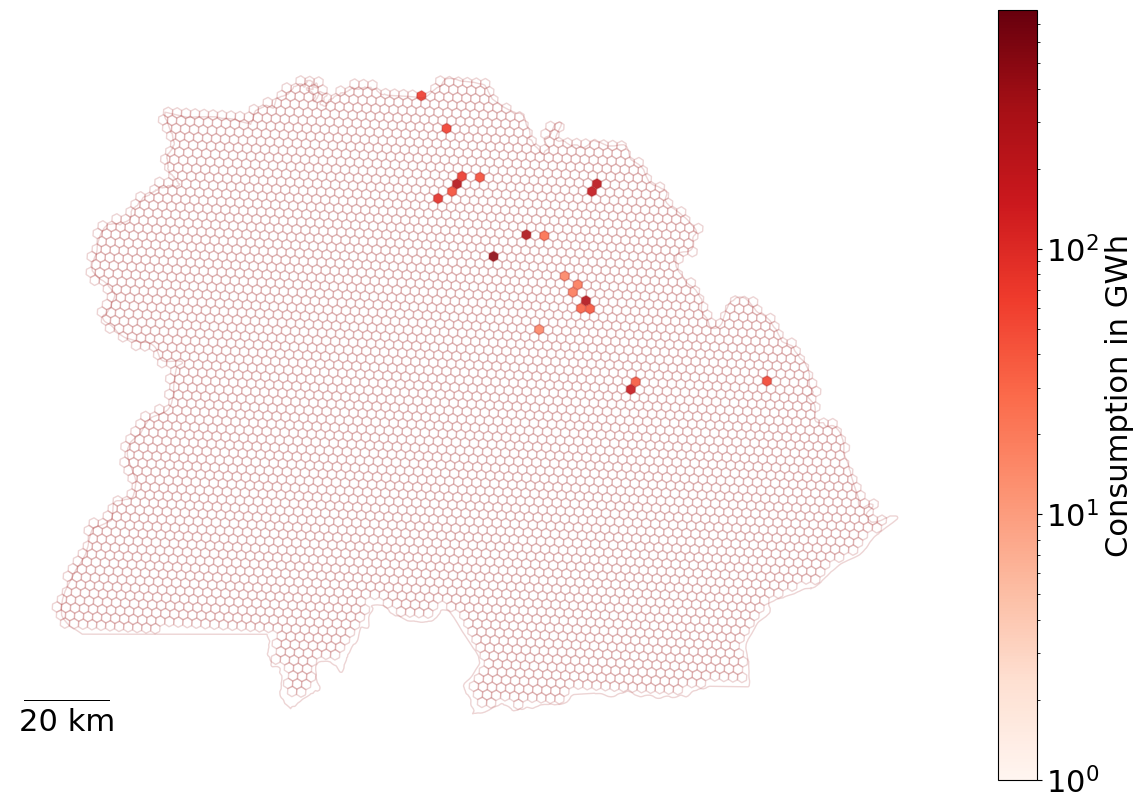

In [22]:
# Plot the industry demand map per cell
# Create the axis first
fig, ax = plt.subplots(figsize=(15, 10))

# Plot data with a log scale value
grid_filtered.sort_values('Copper_elec_GWh', ascending=True).plot(
    ax=ax, column='Copper_elec_GWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['Copper_elec_GWh'].max()),
    legend_kwds={"label": "Consumption in GWh"})

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf_filtered.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
hexagons_filtered.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# lines_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

# # ax.set_aspect('equal', 'box')
# # txt = ax.set_title('Electricity in the mining sector in {} (GWh)'.format(area) )
ax.add_artist(scalebar)
ax.set_axis_off()
# Save plot as figure 
plt.savefig(config.INDUSTRY_OUTPUT_DIR / 'map_industry_copper_log.png', bbox_inches='tight')

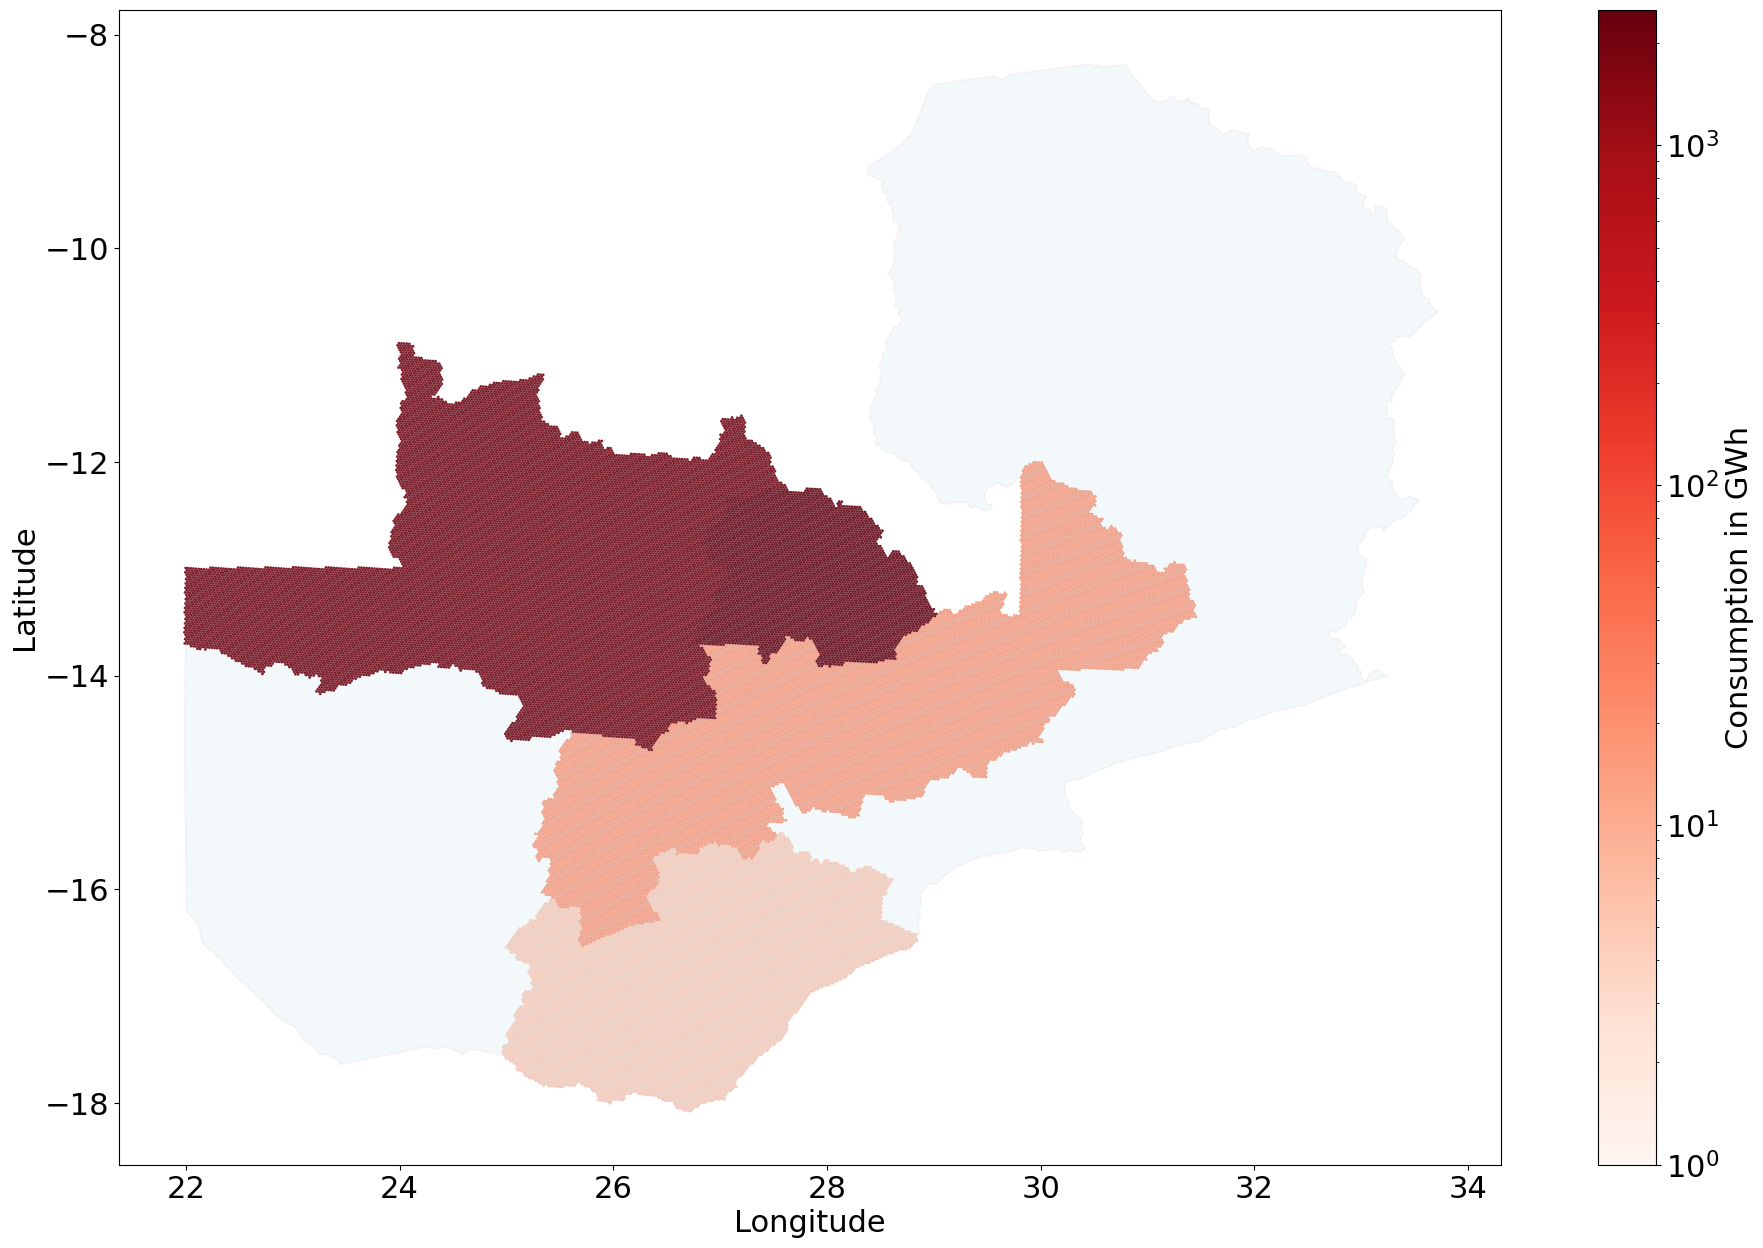

In [23]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('total_copper_elec_perregion', ascending=True).plot(
    ax=ax, column='total_copper_elec_perregion', cmap="Reds", legend=True, alpha=0.9, 
    norm=colors.LogNorm(vmin = 1, vmax=grid['total_copper_elec_perregion'].max()),
    legend_kwds={"label": "Consumption in GWh"})

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.05)
ax.set_aspect('equal', 'box')
# ax.set_title('Electricity in the copper sector in Zambia (GWh)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

from matplotlib.ticker import FuncFormatter

# fmt = lambda x, pos: '{:.1%}'.format(x)
# cbar = plt.colorbar(format=FuncFormatter(fmt))

# Save plot as figure 
plt.savefig(config.INDUSTRY_OUTPUT_DIR / 'map_industry_copper_log_region.png', bbox_inches='tight')